In [13]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import os
from functools import partial
import scipy
import scipy.optimize

In [3]:
def cart2pol(x, y):
    r = np.sqrt(x**2 + y**2)
    theta = np.arctan2(y, x)
    return(theta, r)

def pol2cart(r, phi):
    x = r * np.cos(phi)
    y = r * np.sin(phi)
    return(x, y)

### Newton's second law for the constrained mass:
$$T-Mg=M\ddot r$$
$$T = M\ddot r + Mg$$

### Newton's second law (in polar form) for the swinging mass:
#### Radius:
$$a_r=gcos\theta - \frac{T}{m}=gcos\theta - \frac{Mg}{m} - \frac{M\ddot r}{m}=gcos\theta - \mu g - \mu \ddot r = \ddot r-r\dot\theta^2$$
$$\ddot r = \frac{g(cos\theta-\mu) + r\dot\theta^2}{1+\mu}$$
#### Angle:
$$a_\theta=-gsin\theta=r\ddot\theta+2\dot r \dot\theta$$
$$\ddot\theta = \frac{-gsin\theta-2\dot r \dot\theta}{r}$$

In [4]:
g = 9.81
# offsets for relevant quantities in the state array
R = 0
RDOT = 1
THETA = 2
THETADOT = 3

def ddt(mu, state, t):
    #some of these have been complicated with newton's 2nd law in polar coord form
    rdotdot = (g*(-mu + np.cos(state[THETA])) + state[R]*state[THETADOT]**2) / (1+mu)
    thetadotdot = (-g*np.sin(state[THETA])-2*state[RDOT]*state[THETADOT])/state[R]
    return np.array([state[RDOT],rdotdot,state[THETADOT],thetadotdot]) #r, rdot, theta, thetadot

def rk4(mu, state, t, dt):
    f0 = ddt(mu, state, t)
    f1 = ddt(mu, state+f0*(dt/2), t + dt/2)
    f2 = ddt(mu, state+f1*(dt/2), t + dt/2)
    f3 = ddt(mu, state+f2*(dt), t + dt)
    s_next = state + (f0 + 2 * f1 + 2 * f2 + f3) * dt / 6
    return s_next

In [5]:
def SAM(mu, init_state, t, show):
    states=[init_state] #this captures all necessary params: r, rdot, theta, thetadot
    times = [0]
    dt = 0.005
    threshold = 0.005

    for i in range(int(t/dt)):
        if(states[-1][0] < threshold * init_state[0]):
            print("Possible singularity. Stopping simulation. (r=%.3f)"%states[-1][0])
            break
        if(states[-1][0] > init_state[0]/threshold):
            print("Possible unbounded solution. Stopping simulation. (r=%.3f)"%states[-1][0])
            break
        states.append(rk4(mu, states[-1], times[-1], dt))
        times.append(times[-1] + dt)
        
    
    # transform and transpose
    states = np.array(states)
    states = states.transpose()

    if show:
        fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
        ax.set_theta_zero_location("S")
        ax.plot(states[THETA], states[R], color='r', linewidth=1)
        plt.title("$\mu = %.3f$, $r_0 = %.3f$, $\\dot{r_0} = %.3f$, $\\theta_0 = %.3f$, $\\dot{\\theta_0} = %.3f$" % (mu, init_state[0], init_state[1], init_state[2], init_state[3]))
        ax.grid(True)
    return states

array([[ 2.        ,  1.99992336,  1.99969344, ...,  1.5317064 ,
         1.54007809,  1.5484863 ],
       [ 0.        , -0.03065742, -0.06130808, ...,  1.67028308,
         1.67819017,  1.68489611],
       [ 1.57079633,  1.57073501,  1.57055105, ...,  1.00594462,
         1.0217697 ,  1.03728818],
       [ 0.        , -0.02452657, -0.04906253, ...,  3.19586985,
         3.13425687,  3.07323683]])

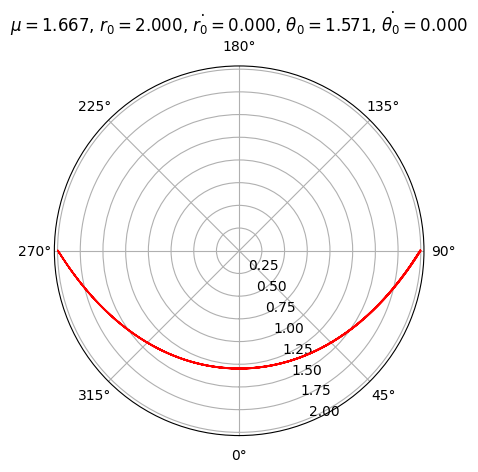

In [7]:
SAM(1.667, np.array([2,0,np.pi/2,0]), 10, True) #known periodic orbit

Possible singularity. Stopping simulation. (r=0.005)


array([[ 2.00000000e+00,  1.99988852e+00,  1.99955410e+00, ...,
         6.05366793e-02,  3.14300347e-02,  5.41272762e-03],
       [ 0.00000000e+00, -4.45906357e-02, -8.91796305e-02, ...,
        -5.83369999e+00, -5.77390526e+00, -3.48916623e+00],
       [ 1.57079633e+00,  1.57073501e+00,  1.57055103e+00, ...,
        -8.79982224e+00, -8.44224282e+00, -5.21208936e+00],
       [ 0.00000000e+00, -2.45272785e-02, -4.90682317e-02, ...,
         3.76946482e+01,  1.39774280e+02,  3.82272899e+03]])

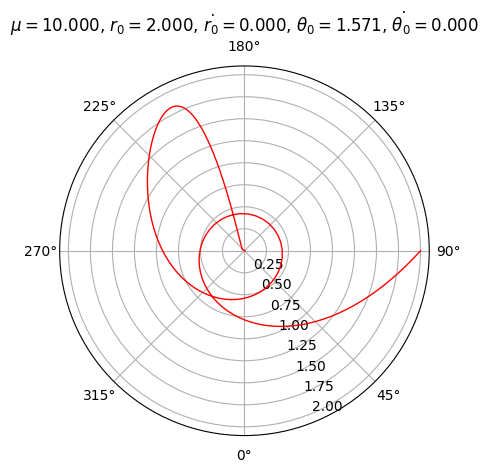

In [8]:
SAM(10, np.array([2,0,np.pi/2,0]), 10, True) #known singular orbit

array([[ 2.        ,  1.9849202 ,  1.96968082, ...,  1.60187449,
         1.58964859,  1.57720726],
       [-3.        , -3.03191923, -3.06382843, ..., -2.42359032,
        -2.46674645, -2.50976019],
       [ 0.1       ,  0.1035203 ,  0.10708193, ..., -2.02527575,
        -2.02035202, -2.01521123],
       [ 0.7       ,  0.70815676,  0.71652971, ...,  0.96348537,
         1.00622627,  1.05031802]])

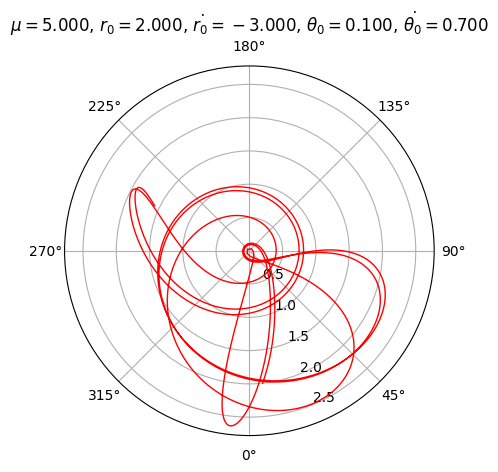

In [9]:
SAM(5, np.array([2,-3,0.1,0.7]), 10, True) #some initial velocity

In [6]:
DOT_SIZE = 90
MIN_STRING_LENGTH = 1.75
DISTANCE_BETWEEN_PULLEYS = 0.5

def update(frame, dots, history, string, res, interval, string_length):
    # prevent t from going beyond the end
    t = frame*int(interval/5)
    t_end = len(res[0])-1
    t = min(t, t_end)

    # mutate path history    
    history.set_xdata(res[THETA][:t])
    history.set_ydata(res[R][:t])
    
    theta = res[THETA][t]
    r = res[R][t]
    
    # mutate swinging mass location
    swinging_dot = dots[0]
    swinging_dot.set_offsets([theta, r])
    
    # mutate vertical mass location
    vertical_dot = dots[1]
    remaining_string_length = string_length - DISTANCE_BETWEEN_PULLEYS - r
    
    alpha = np.arctan2(remaining_string_length, DISTANCE_BETWEEN_PULLEYS)
    angle = -np.pi/2 + alpha
    distance = np.sqrt(remaining_string_length**2 + DISTANCE_BETWEEN_PULLEYS**2)
    vertical_dot.set_offsets([angle, distance])
    
    # mutate string
    positions = np.array([[angle, distance],
        [-np.pi/2, DISTANCE_BETWEEN_PULLEYS],
        [0, 0],
        [theta, r]])
    string.set_data(np.transpose(positions))
    
    return [history, swinging_dot, vertical_dot, string]

def anim(mu, state, t, interval):
    # data for animation
    res = SAM(mu, state, t, False)

    # find string length such that remaining string length is not negative
    string_length = max(MIN_STRING_LENGTH, max(res[R]) + 0.1 + DISTANCE_BETWEEN_PULLEYS)
    
    # set up polar coords
    fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
    ax.set_theta_zero_location("S")
    history = ax.plot(res[THETA], res[R], color='r', linewidth=1)[0] # past movement
    ax.grid(True)
    
    #ensure that vertical dot does not go out of limits
    ax.set_ylim([0, np.sqrt((string_length-DISTANCE_BETWEEN_PULLEYS)**2+DISTANCE_BETWEEN_PULLEYS**2)])
    
    initial_theta = res[THETA][0]
    initial_r = res[R][0]
    
    swinging_dot = ax.scatter(initial_theta, initial_r, s=DOT_SIZE, c='black')
    vertical_dot = ax.scatter(initial_theta, initial_r, s=DOT_SIZE, c='blue')

    string = ax.plot(initial_theta, initial_r, color='gray', linewidth=1)[0] #idk why it returns it in a list

    ani = animation.FuncAnimation(fig=fig, func=partial(
        update, 
        history=history, 
        dots=[swinging_dot, vertical_dot],
        string=string,
        res=res, 
        interval=interval,
        string_length=string_length), frames=int(len(res[0])*5/interval), interval=interval)

    # filename checks and file creation
    i = 1
    filename = "gifs/example_mu%.3f.gif" % (mu)
    if os.path.exists(filename):
        while os.path.exists("gifs/example_mu%.3f_%s.gif" % (mu, i)):
            i += 1
        filename = "gifs/example_mu%.3f_%s.gif" % (mu, i)
    ani.save(filename=filename, writer="pillow", fps=int(1000/interval))

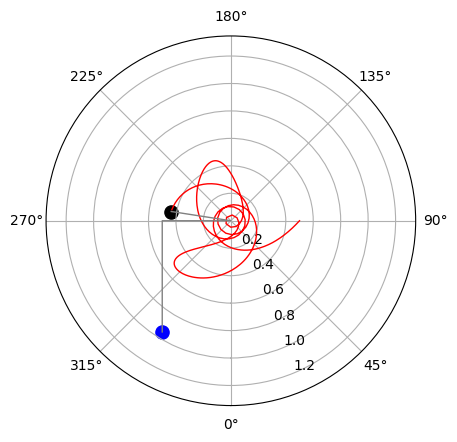

In [11]:
anim(mu=10.3, state=np.array([0.5, 0, np.pi/2, 0]), t=2, interval=30)

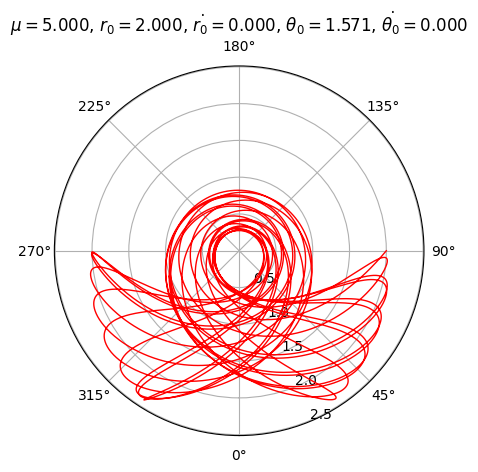

In [12]:
result = SAM(5, np.array([2,0,np.pi/2,0]), 30, True)

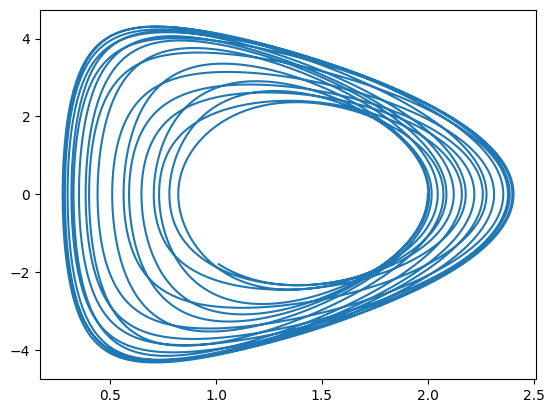

In [13]:
plt.plot(result[R], result[RDOT])
#phase plot

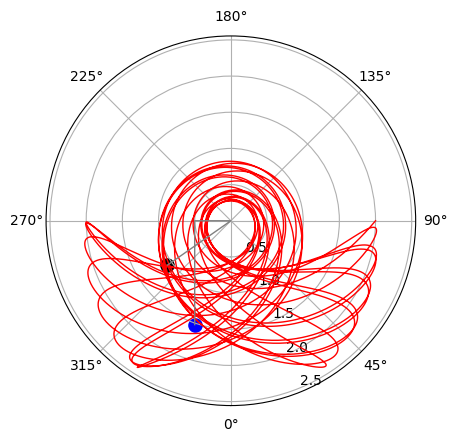

In [14]:
anim(mu=5, state=np.array([2, 0, np.pi/2, 0]), t=30, interval=30)

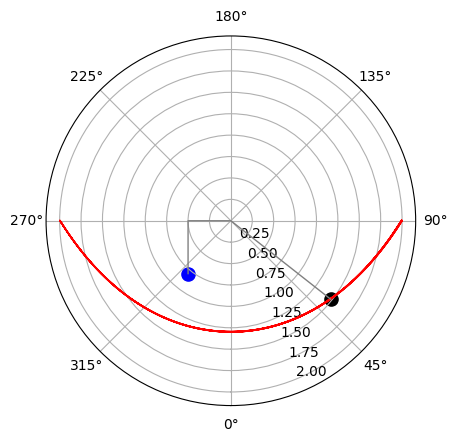

In [15]:
anim(1.667, np.array([2,0,np.pi/2,0]), t=10, interval=30) #known periodic orbit

# 3 Dimensions

### Newton's second law for the constrained mass:
$$T-Mg=M\ddot r$$
$$T = M\ddot r + Mg$$

### Coordinate system:
We will be using a spherical coordinate system with the origin at the point where the swinging mass' rope connects to the fixed part of the rope. $\theta$ will be measured upward from the downward vertical, and $\phi$ will be measured *clockwise* from an arbitrary direction, so that the coordinate system remains right-handed.

![](https://raw.githubusercontent.com/pgot/swingingatwood/main/img/coords.jpg "Coordinate system")

### Newton's laws for spherical coordinates:
Note that the gravitational force is only in the r,$\theta$ directions, and tension in the r direction. So $\ddot \phi$ is 0, and we can use our equations from the first part with minor additions for the extra azimuthal angle $\phi$.
#### $r$:
$$a_r = g\cos\theta - \mu g - \mu \ddot r = \ddot r - r\dot\theta^2 - r\dot\phi^2\sin^2\theta$$
$$\ddot r = \frac{g(\cos\theta-\mu) + r\dot\theta^2 + r\dot\phi^2\sin^2\theta}{1+\mu}$$
#### $\theta$:
$$a_\theta = -g\sin\theta = r\ddot\theta + 2\dot r\dot\theta - r\dot\phi^2\sin\theta\cos\theta$$
$$\ddot\theta = \frac{-g\sin\theta-2\dot r \dot\theta}{r} + \dot\phi^2\sin\theta\cos\theta$$
#### $\phi$:
$$a_\phi = 0 = 2\dot r\dot\phi\sin\theta + r\ddot\phi\sin\theta + 2r\dot\theta\dot\phi\cos\theta$$
$$\ddot\phi = \frac{- 2\dot r\dot\phi\sin\theta - 2r\dot\theta\dot\phi\cos\theta}{r\sin\theta}
= - \frac{ 2\dot r\dot\phi}{r} - \frac{2\dot\theta\dot\phi}{\tan\theta}
= - 2\dot\phi(\frac{\dot r}{r} + \frac{\dot\theta}{\tan\theta})$$

In [7]:
# new coord variables
PHI = 4
PHIDOT = 5

def ddt3d(mu, state, t):
    rdotdot = (g*(-mu + np.cos(state[THETA])) + state[R]*state[THETADOT]**2 + state[R]*state[PHIDOT]**2*np.sin(state[THETA])**2) / (1+mu)
    thetadotdot = (-g*np.sin(state[THETA])-2*state[RDOT]*state[THETADOT])/state[R] + state[PHIDOT]**2*np.sin(state[THETA])*np.cos(state[THETA])
    phidotdot = -2*state[PHIDOT]*(state[RDOT]/state[R] + state[THETADOT]/np.tan(state[THETA]))
    return np.array([state[RDOT],rdotdot,state[THETADOT],thetadotdot,state[PHIDOT],phidotdot]) #r, rdot, theta, thetadot, phi, phidot

def rk43d(mu, state, t, dt):
    f0 = ddt3d(mu, state, t)
    f1 = ddt3d(mu, state+f0*(dt/2), t + dt/2)
    f2 = ddt3d(mu, state+f1*(dt/2), t + dt/2)
    f3 = ddt3d(mu, state+f2*(dt), t + dt)
    s_next = state + (f0 + 2 * f1 + 2 * f2 + f3) * dt / 6
    return s_next

In [8]:
# coord conversion tools

def sph2cart(r, theta, phi):
    x = r*np.sin(theta)*np.cos(phi)
    y = r*np.sin(theta)*np.sin(phi)
    z = r*np.cos(theta)
    return (x, y, z)

def cart2sph(x, y, z):
    r = np.sqrt(x**2+y**2+z**2)
    theta = np.arccos(z/r)
    phi = np.arctan2(y, x)
    return (r, theta, phi)

In [9]:
def SAM3d(mu, init_state, t, show, figsize=(6.4, 4.8)):
    states=[init_state] #this captures all necessary params: r, rdot, theta, thetadot
    times = [0]
    dt = 0.005
    threshold = 0.005

    for i in range(int(t/dt)):
        if(states[-1][0] < threshold * init_state[0]):
            print("Possible singularity. Stopping simulation. (r=%.3f)"%states[-1][0])
            break
        if(states[-1][0] > init_state[0]/threshold):
            print("Possible unbounded solution. Stopping simulation. (r=%.3f)"%states[-1][0])
            break
        states.append(rk43d(mu, states[-1], times[-1], dt))
        times.append(times[-1] + dt)
        
    
    # transform and transpose
    states = np.array(states)
    states = states.transpose()

    if show:
        fig, ax = plt.subplots(subplot_kw={'projection': '3d'}, figsize=figsize)
        temp = sph2cart(states[R], states[THETA], states[PHI])
        ax.plot(temp[0], temp[1], temp[2], color='r', linewidth=1)
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        ax.set_zlabel('z')
        limit = max(states[R])
        ax.set_xlim(-limit, limit)
        ax.set_ylim(-limit, limit)
        ax.set_zlim(-limit, limit)
        ax.invert_yaxis()
        ax.invert_zaxis()
        plt.title("$\\mu = %.3f$, $r_0 = %.3f$, $\\dot{r_0} = %.3f$, $\\theta_0 = %.3f$, $\\dot{\\theta_0} = %.3f$, $\\phi_0 = %.3f$, $\\dot{\\phi_0} = %.3f$" % 
                  (mu, init_state[R], init_state[RDOT], init_state[THETA], init_state[THETADOT], init_state[PHI], init_state[PHIDOT]))
    return states

sanity check with $\dot\phi$ as 0 so it becomes a 2d solution

array([[ 2.        ,  1.99989781,  1.99959126, ...,  1.03084506,
         1.02161724,  1.01254157],
       [ 0.        , -0.0408745 , -0.08174599, ..., -1.86050403,
        -1.83048543, -1.79964799],
       [ 1.57079633,  1.57073501,  1.57055104, ..., -1.13238262,
        -1.1768333 , -1.22186392],
       [ 0.        , -0.02452709, -0.04906671, ..., -8.83202593,
        -8.9481919 , -9.06398544],
       [-0.05      , -0.05      , -0.05      , ..., -0.05      ,
        -0.05      , -0.05      ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

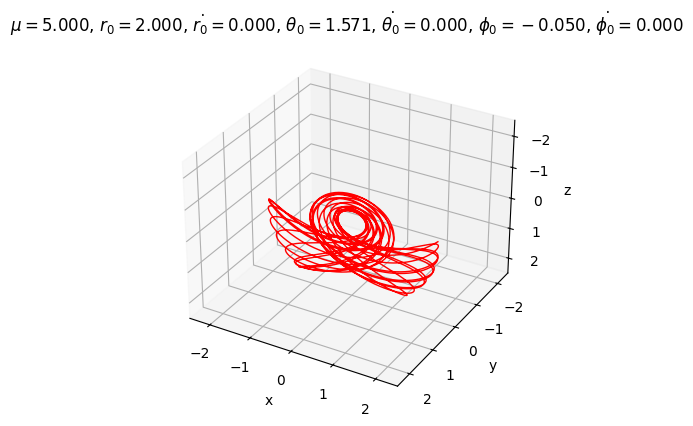

In [58]:
SAM3d(5, [2, 0, np.pi/2, 0, -.05, 0], 30, True)

array([[ 2.        ,  1.99992336,  1.99969344, ...,  1.9952565 ,
         1.9939813 ,  1.99255412],
       [ 0.        , -0.03065742, -0.06130808, ..., -0.23982397,
        -0.27024835, -0.30061249],
       [ 1.57079633,  1.57073501,  1.57055105, ..., -1.56708553,
        -1.56606258, -1.56491517],
       [ 0.        , -0.02452657, -0.04906253, ...,  0.19216873,
         0.21702143,  0.2419577 ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

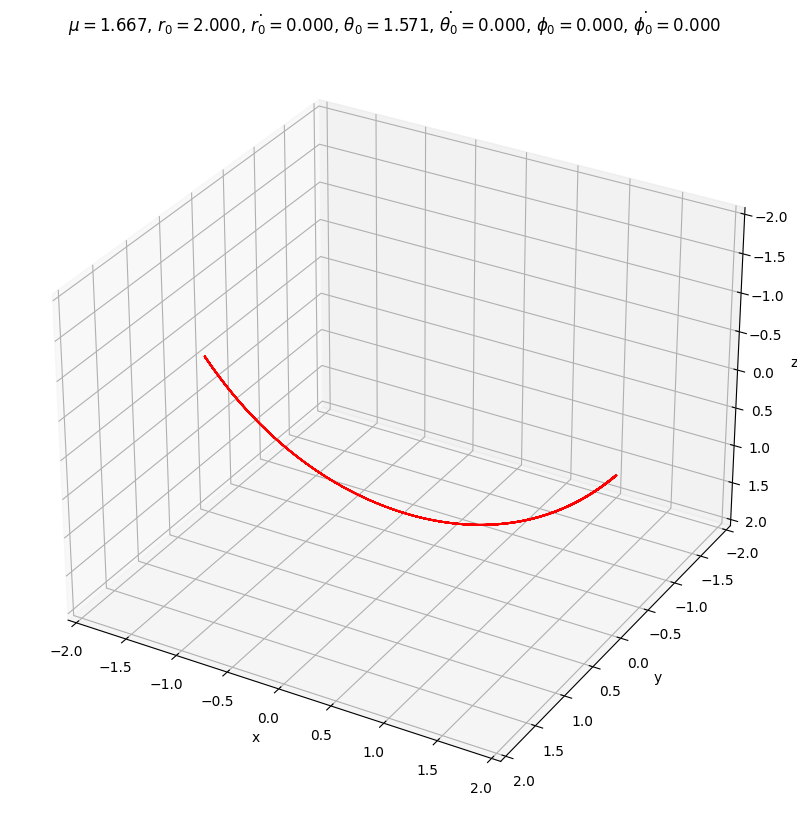

In [10]:
SAM3d(1.667, [2, 0, np.pi/2, 0, 0, 0], 30, True, figsize=(160/9, 10)) # known periodic orbit

In [10]:
DOT_SIZE_3D = 50

def update3d(frame, dots, history, string, res, interval, string_length):
    # prevent t from going beyond the end
    t = frame*int(interval/5)
    t_end = len(res[0])-1
    t = min(t, t_end)

    # change from spherical to cartesian since no such thing as spherical plot
    cart = sph2cart(res[R], res[THETA], res[PHI])

    # mutate path history    
    history.set_data_3d(cart[0][:t], cart[1][:t], cart[2][:t])
    
    r = res[R][t]
    
    # mutate swinging mass location
    swinging_dot = dots[0]
    swinging_dot._offsets3d = ([cart[0][t]], [cart[1][t]], [cart[2][t]])
    
    # mutate vertical mass location
    vertical_dot = dots[1]
    remaining_string_length = string_length - DISTANCE_BETWEEN_PULLEYS - r
    vertical_dot._offsets3d = ([-DISTANCE_BETWEEN_PULLEYS], [0], [remaining_string_length])
    
    # mutate string
    positions = np.array([[-DISTANCE_BETWEEN_PULLEYS, 0, remaining_string_length], #vertical mass
        [-DISTANCE_BETWEEN_PULLEYS, 0, 0], # vertical pulley
        [0, 0, 0], #swinging pulley
        [cart[0][t], cart[1][t], cart[2][t]]]) #swinging mass
    string.set_data_3d(np.transpose(positions))
    
    return [history, swinging_dot, vertical_dot, string]

def anim3d(mu, state, t, interval, figsize=(6.4, 4.8)):
    # data for animation
    res = SAM3d(mu, state, t, False)

    # find string length such that remaining string length is not negative
    string_length = max(MIN_STRING_LENGTH, max(res[R]) + 0.1 + DISTANCE_BETWEEN_PULLEYS)
    
    # set up plot
    fig, ax = plt.subplots(subplot_kw={'projection': '3d'}, figsize=figsize)
    plt.figure(figsize=figsize)
    cart = sph2cart(res[R], res[THETA], res[PHI])
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    limit = max(res[R])
    ax.set_xlim(-limit, limit)
    ax.set_ylim(-limit, limit)
    ax.set_zlim(-limit, limit)
    ax.invert_yaxis()
    ax.invert_zaxis()
    history = ax.plot(cart[0], cart[1], cart[2], color='r', linewidth=1)[0]
    
    initial_x = cart[0][0]
    initial_y = cart[1][0]
    initial_z = cart[2][0]
    
    swinging_dot = ax.scatter(initial_x, initial_y, initial_z, s=DOT_SIZE_3D, c='black')
    vertical_dot = ax.scatter(initial_x, initial_y, initial_z, s=DOT_SIZE_3D, c='blue')

    string = ax.plot(initial_x, initial_y, initial_z, color='gray', linewidth=1)[0] #idk why it returns it in a list

    ani = animation.FuncAnimation(fig=fig, func=partial(
        update3d, 
        history=history, 
        dots=[swinging_dot, vertical_dot],
        string=string,
        res=res, 
        interval=interval,
        string_length=string_length), frames=int(len(res[0])*5/interval), interval=interval)

    # filename checks and file creation
    i = 1
    filename = "gifs/3d_mu%.3f.gif" % (mu)
    if os.path.exists(filename):
        while os.path.exists("gifs/3d_mu%.3f_%s.gif" % (mu, i)):
            i += 1
        filename = "gifs/3d_mu%.3f_%s.gif" % (mu, i)
    ani.save(filename=filename, writer="pillow", fps=int(1000/interval))

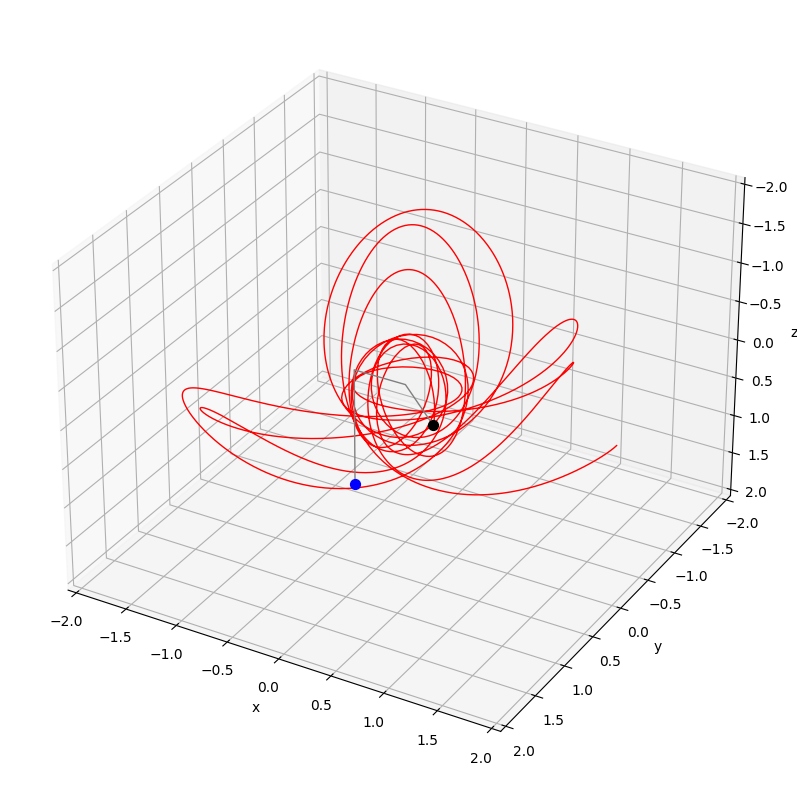

<Figure size 1777.78x1000 with 0 Axes>

In [21]:
anim3d(mu=10, state=np.array([2, 0, np.pi/2, 0, 0, 0.8]), t=10, interval=30, figsize=(160/9, 10))

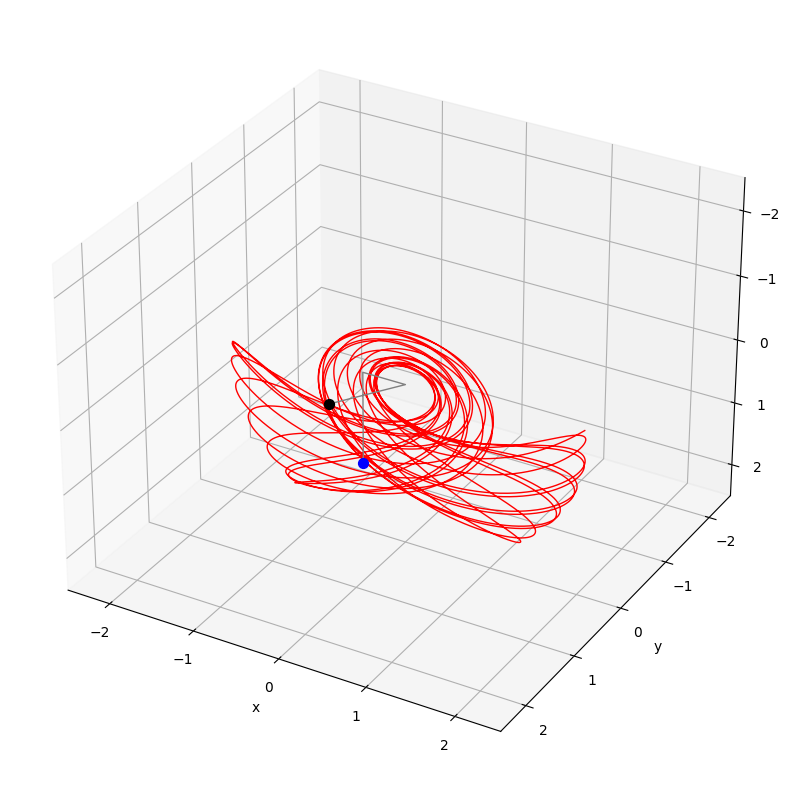

<Figure size 1777.78x1000 with 0 Axes>

In [22]:
anim3d(mu=5, state=np.array([2, 0, np.pi/2, 0, -.05, 0]), t=30, interval=30, figsize=(160/9, 10))

# Energy conservation

we consider the GPE and KE of the swinging and vertical object

the velocity of the swinging object from spherical coordinates is given by:

$$\begin{align*}
v &= \sqrt{{\dot x}^2 + {\dot y}^2 + {\dot z}^2} \\
&= \sqrt{{\dot r}^2+r^2{\dot\theta}^2 + r^2\sin^2(\theta){\dot\phi}^2} \
\end{align*}$$

In [78]:
def SAM3d_energyplot(mu, state, t):
# mu = vertical mass/swinging mass
# vertical mass = swinging mass * mu
    states = SAM3d(mu, state, t, True) #known periodic orbit
    plt.show()
    states = np.transpose(states)
    energy = []

    for state in states:
        r = state[R]
        theta = state[THETA]
        phi = state[PHI]
        rdot = state[RDOT]
        thetadot = state[THETADOT]
        phidot = state[PHIDOT]

        # calculate energy of swinging thing
        [x,y,z] = sph2cart(r, theta, phi)
        GPE = -z * 1 * g
    
        v_squared = rdot**2 + (r**2)*thetadot**2 + (r**2)*np.sin(theta)**2*phidot**2
        KE = 0.5 * 1 * v_squared

        # calculate energy of vertical thing
        string_length = 8 # or something arbitrary idk
        remaining_string_length = string_length - r

        GPE_vertical = -mu * g * remaining_string_length
        KE_vertical = 0.5 * mu * rdot ** 2
        energy.append(GPE+KE+GPE_vertical+KE_vertical)

    dt = 0.005
    times = [0]
    for i in range(int(t/dt)):
        times.append(times[-1] + dt)

    plt.plot(times, energy)
    plt.show()


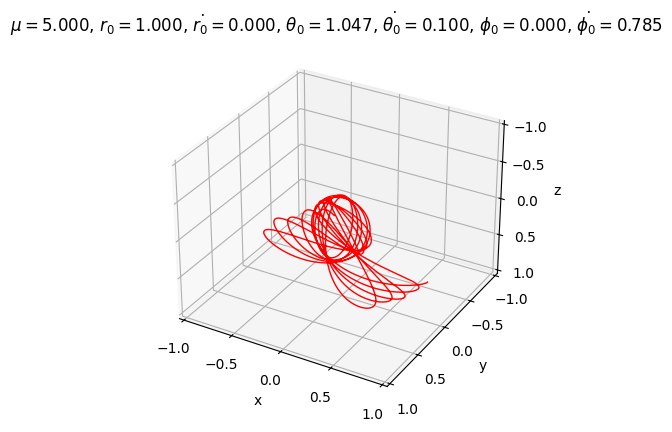

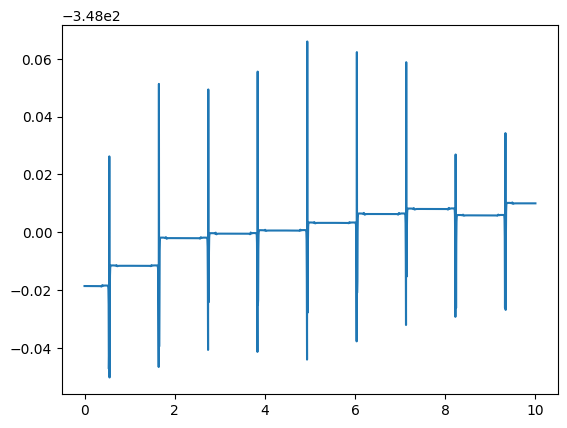

In [79]:
SAM3d_energyplot(mu = 5, state = [1, 0, np.pi/3, 0.1, 0, np.pi/4], t = 10)

We see that energy is conserved with very minor deviations


# Investigations for stability

We know of 1 trivial stable solution that does not reduce into just 2D movement: uniform circular motion about the $\phi$ coordinate.

In this case, $\dot r$, $\ddot r$, $\dot \theta$, $\ddot \theta$ and $\ddot \phi$ are all 0.

$$ T = Mg $$
$$ T\sin\theta = mr\sin\theta\dot\phi^2 $$
$$ \mu g = r\dot\phi^2 $$
$$ \dot\phi = \sqrt{\frac{\mu g}{r}} $$
$$ T\cos\theta = mg $$
$$ \cos\theta = \frac{1}{\mu} $$
Here, we get a family of solutions, with 1 unique solution for each value of $\mu$ (r usually acts as a scaling).

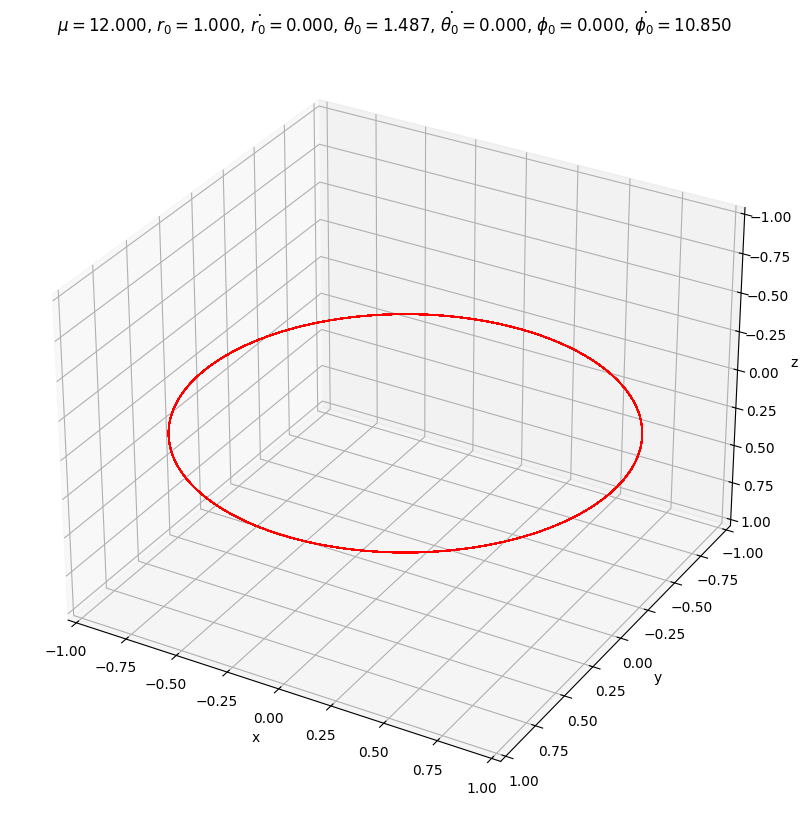

In [84]:
# circular motion variables we can change
c_mu = 12
c_r = 1
SAM3d(c_mu, [c_r, 0, np.arccos(1/c_mu), 0, 0, np.sqrt((c_mu*g)/c_r)], 30, True, figsize=(160/9, 10)) # circular
plt.show()

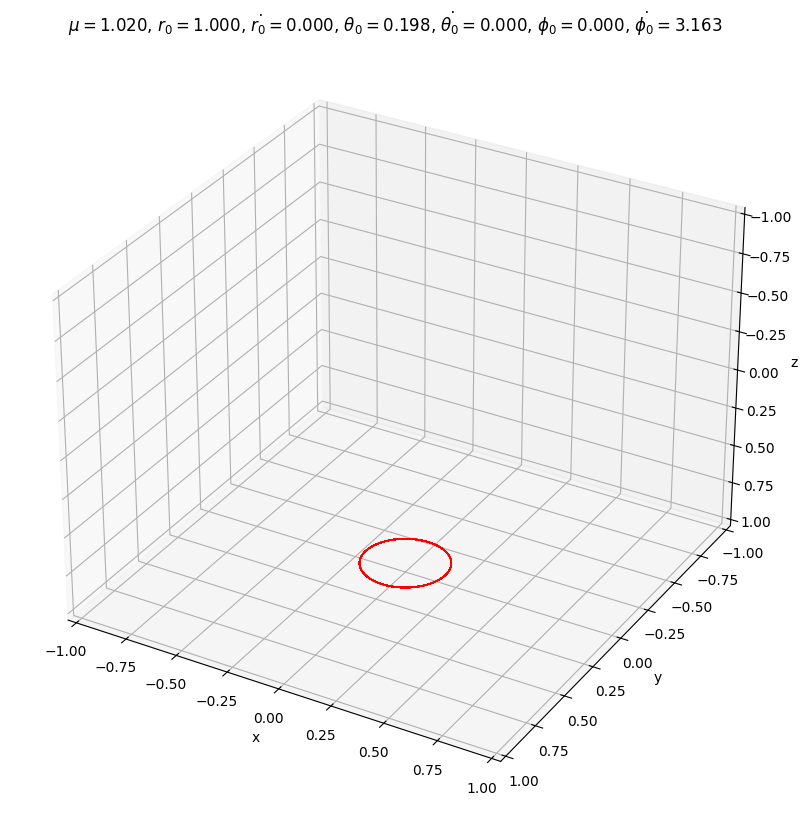

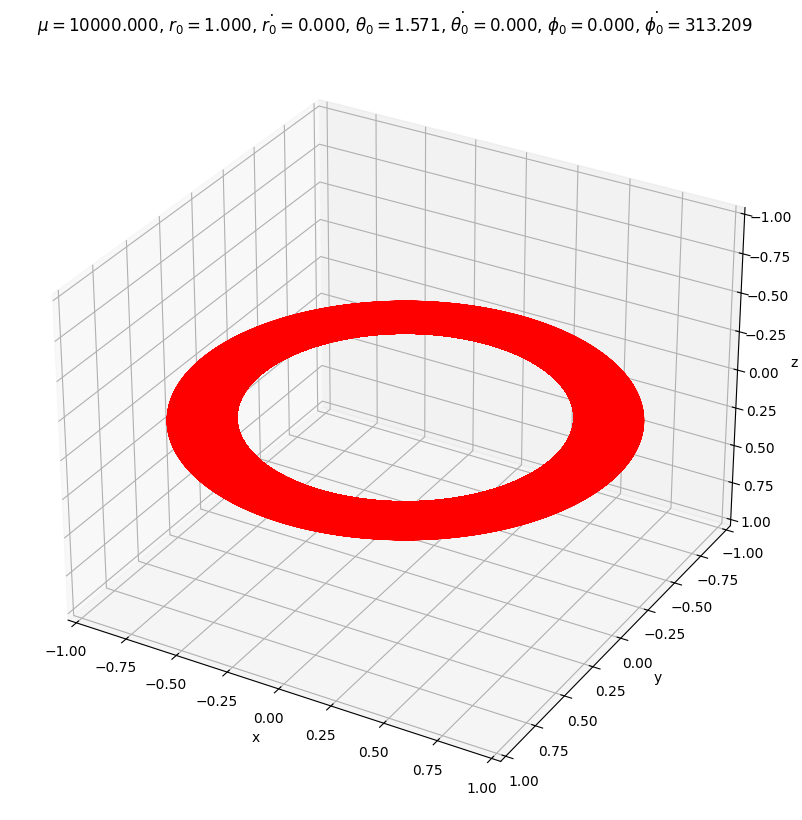

In [86]:
# see how trajectory changes with change in mu
c_mu = 1.02
SAM3d(c_mu, [c_r, 0, np.arccos(1/c_mu), 0, 0, np.sqrt((c_mu*g)/c_r)], 30, True, figsize=(160/9, 10))
c_mu = 10000
SAM3d(c_mu, [c_r, 0, np.arccos(1/c_mu), 0, 0, np.sqrt((c_mu*g)/c_r)], 30, True, figsize=(160/9, 10))
plt.show()

Note that the observed thickness of the ring is caused by the extremely large $\dot\phi$. This causes the next time step to have a large difference in $\phi$ and be located further away on the circle, and matplotlib draws them with a straight line, resulting in a chord instead of an arc. With many time steps, this develops into a 'thickness', which gets worse with larger mu. Decreasing the timestep should decrease this effect, as this is merely an artefact of computation and not an actual physical effect.

## Perturbation

Now, we investigate the nature of this stability by giving the system a small perturbation.

#### Perturb $r$

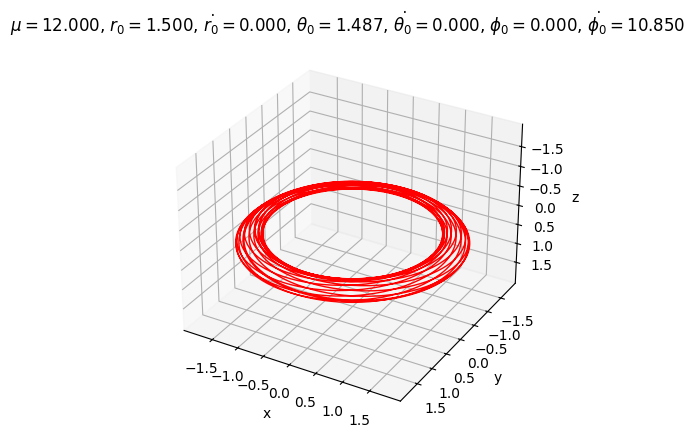

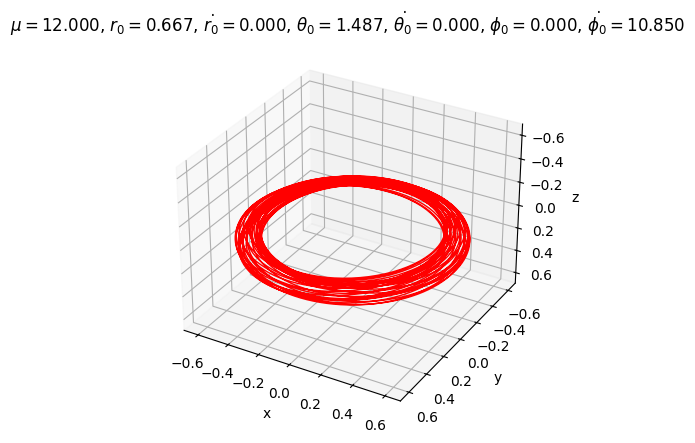

In [87]:
c_mu = 12
SAM3d(c_mu, [c_r*1.5, 0, np.arccos(1/c_mu), 0, 0, np.sqrt((c_mu*g)/c_r)], 15, True, figsize=(80/9, 5))
SAM3d(c_mu, [c_r/1.5, 0, np.arccos(1/c_mu), 0, 0, np.sqrt((c_mu*g)/c_r)], 15, True, figsize=(80/9, 5))
plt.show()

There appears to be some precession-like behavior, with an elliptical orbit rotating. We can see this better with animation.

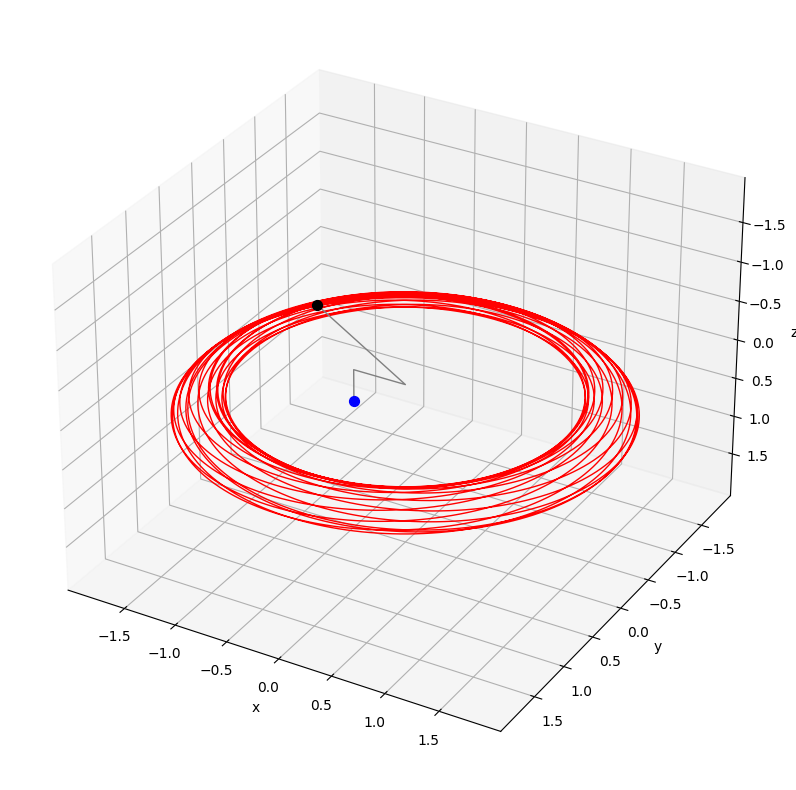

<Figure size 1777.78x1000 with 0 Axes>

In [70]:
anim3d(mu=c_mu, state=np.array([c_r*1.5, 0, np.arccos(1/c_mu), 0, 0, np.sqrt((c_mu*g)/c_r)]), t=15, interval=60, figsize=(160/9, 10))

But something absurd appears to be occurring, where the swinging mass completes 2 circles in one period, one of which is smaller than the other, meeting at a common point.

![](https://raw.githubusercontent.com/pgot/swingingatwood/main/img/r_12.jpg "The orbit after 1 period")

Text(0, 0.5, 'r')

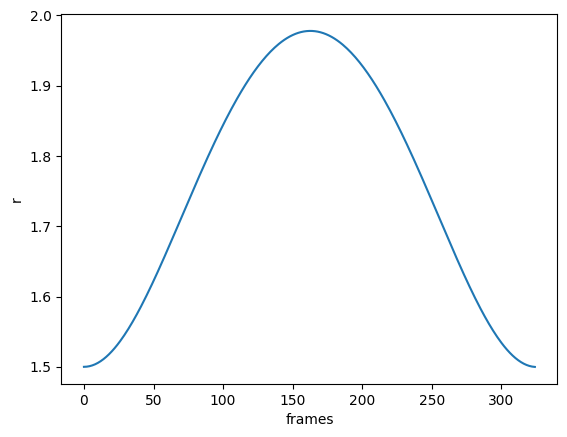

In [84]:
r_12_result = SAM3d(c_mu, [c_r*1.5, 0, np.arccos(1/c_mu), 0, 0, np.sqrt((c_mu*g)/c_r)], 15, False, figsize=(80/9, 5))

plt.plot(r_12_result[R][:325])
plt.xlabel("frames")
plt.ylabel("r")

We can see that 1 period is about 325 frames, so around 1.63 seconds. We will now plot a graph of $r$ against $\phi$ to try and guess a relation.

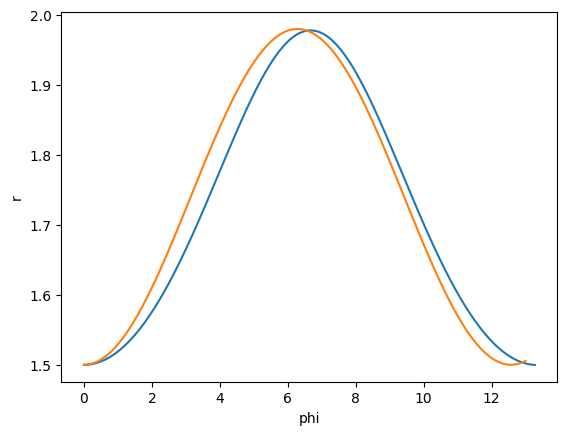

In [93]:
# r against phi
plt.plot(r_12_result[PHI][:325], r_12_result[R][:325])
plt.xlabel("phi")
plt.ylabel("r")

# our guess of a function
xs = np.linspace(0, 13, 100)
ys = 1.74 - 0.24*np.cos(xs/2)
plt.plot(xs, ys)
# TODO: add legend

We can see that the graph of $r$ against $\phi$ matches our expectations that r varies with twice the period of one orbit, completing a rough sine wave. The phase offset at larger $\phi$ can be attributed to the **precession** effect, with radius returning to a minimum value slightly later than when the same $\phi$ has been reached, causing the entire orbit to rotate.<br>

We shall now vary $r$ for lower values of $\mu$.

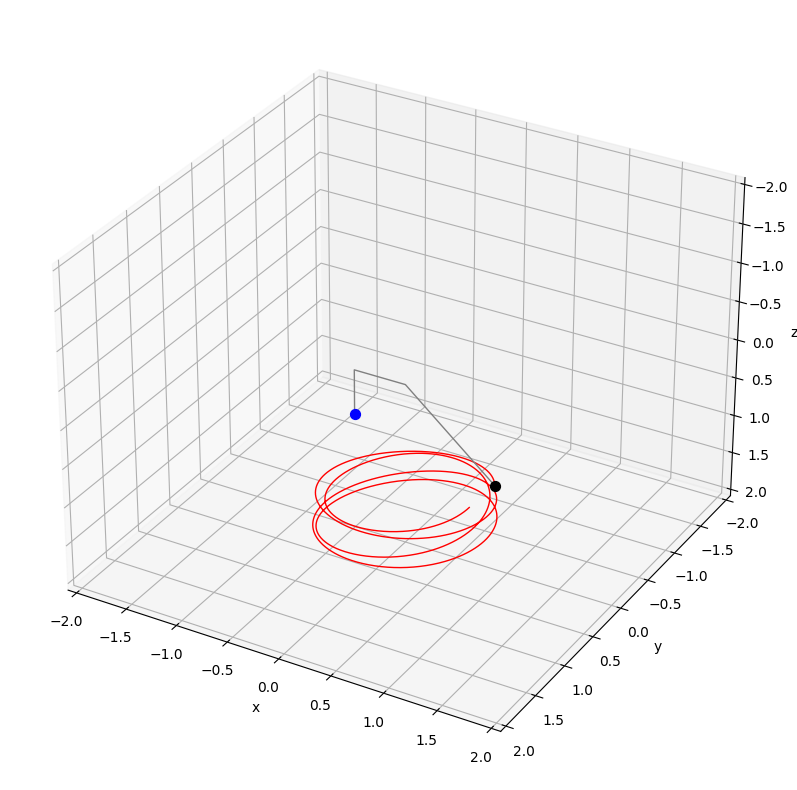

<Figure size 1777.78x1000 with 0 Axes>

In [101]:
c_mu = 1.1
anim3d(mu=c_mu, state=np.array([c_r*1.5, 0, np.arccos(1/c_mu), 0, 0, np.sqrt((c_mu*g)/c_r)]), t=10, interval=60, figsize=(160/9, 10))

This appears to be a circular orbit moving up and down with changing radius and z position, such that it appears to be on the surface of a cone.

#### Perturb $\theta$

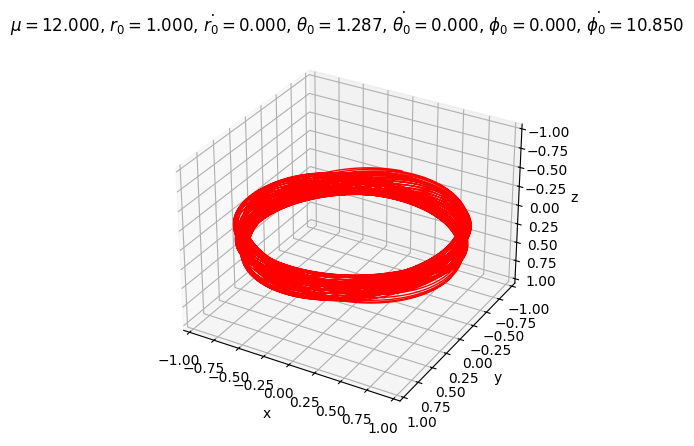

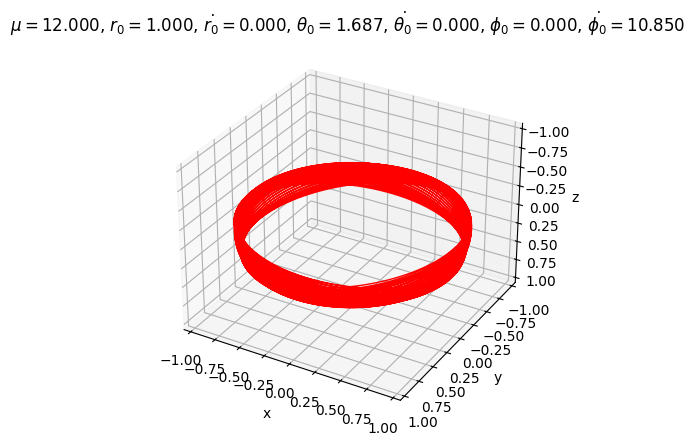

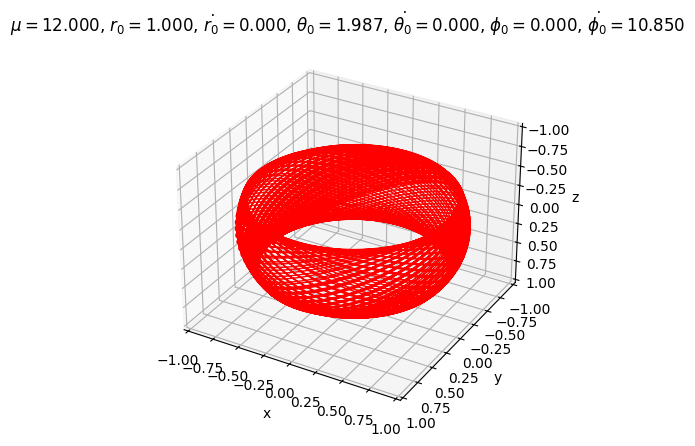

In [88]:
c_mu = 12
SAM3d(c_mu, [c_r, 0, np.arccos(1/c_mu)-0.2, 0, 0, np.sqrt((c_mu*g)/c_r)], 30, True, figsize=(80/9, 5))
SAM3d(c_mu, [c_r, 0, np.arccos(1/c_mu)+0.2, 0, 0, np.sqrt((c_mu*g)/c_r)], 30, True, figsize=(80/9, 5))
SAM3d(c_mu, [c_r, 0, np.arccos(1/c_mu)+0.5, 0, 0, np.sqrt((c_mu*g)/c_r)], 60, True, figsize=(80/9, 5))
plt.show()

Small perturbations of $\theta$ from a perfect circular orbit appear to showcase precession behavior, with the orbiting plane rotating about the pivot point. We can see this effect clearer with animation.

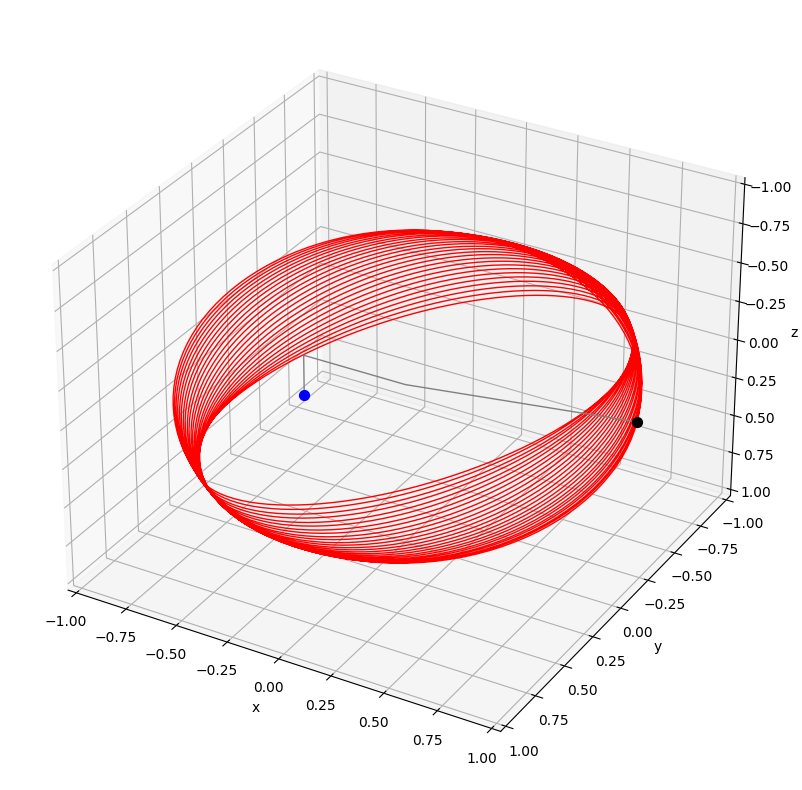

<Figure size 1777.78x1000 with 0 Axes>

In [99]:
anim3d(mu=c_mu, state=np.array([c_r, 0, np.arccos(1/c_mu)+0.4, 0, 0, np.sqrt((c_mu*g)/c_r)]), t=15, interval=30, figsize=(160/9, 10))

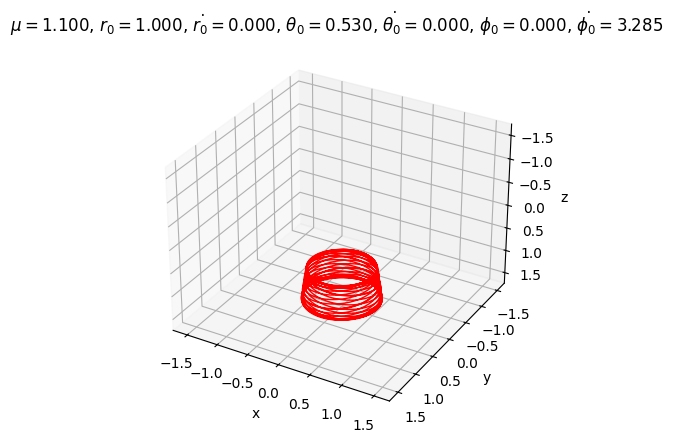

In [89]:
c_mu = 1.1
SAM3d(c_mu, [c_r, 0, np.arccos(1/c_mu)+0.1, 0, 0, np.sqrt((c_mu*g)/c_r)], 60, True, figsize=(80/9, 5))
plt.show()

With smaller values of $\mu$, the precession effect appears to be different.

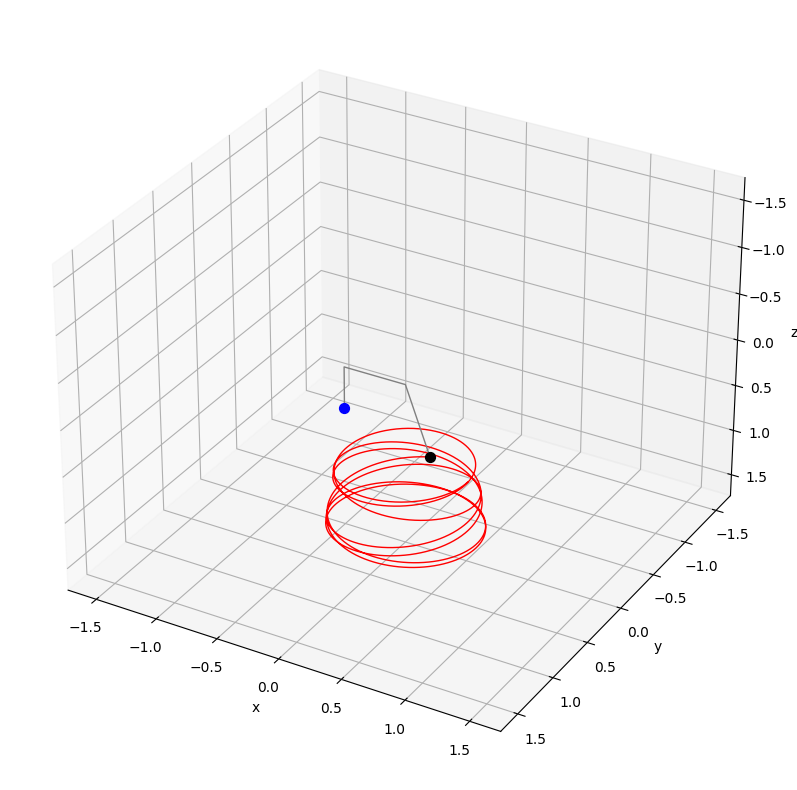

<Figure size 1777.78x1000 with 0 Axes>

In [103]:
anim3d(mu=c_mu, state=np.array([c_r, 0, np.arccos(1/c_mu)+0.1, 0, 0, np.sqrt((c_mu*g)/c_r)]), t=15, interval=60, figsize=(160/9, 10))

This appears to not be precession, but a combination of orbiting and oscillatory up-down motion, producing a series of Lissajous-like curves, especially for small times $t$.<br>

We can also notice that in all of these examples, all of the swinging mass' motion appears to be on some surface that is rotationally symmetric about the azimuthal angle $\phi$. This appears to be the surface of a cone in this previous example where $\mu = 1.1$, and the surface of a sphere when $\mu = 12$. It is likely that as we move to higher values of $\mu$, there is a smooth transition from the surface of a cone to the surface of a sphere, due to the unperturbed 'orbital plane' moving closer to the pivot point at the origin.

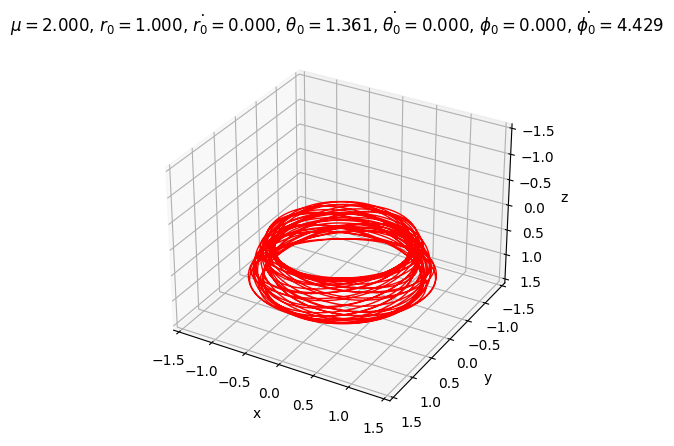

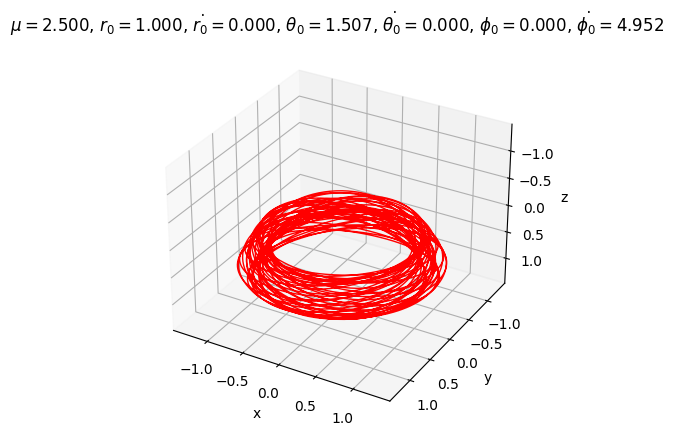

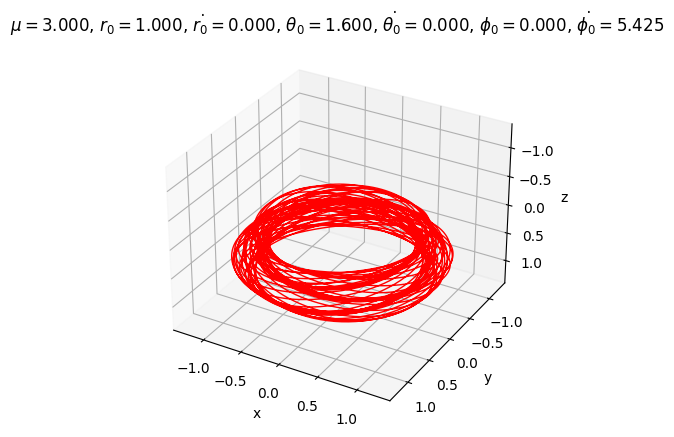

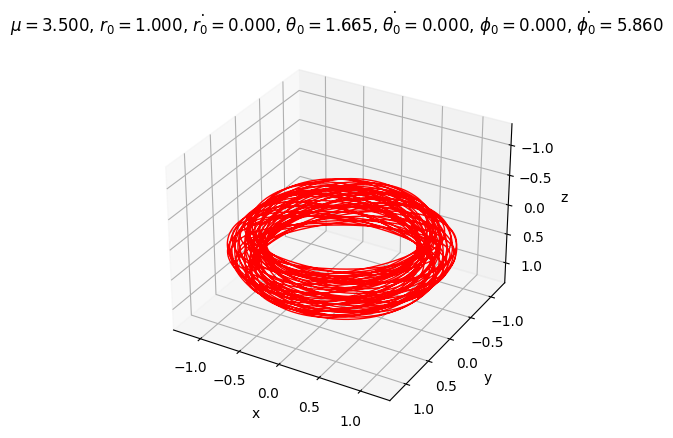

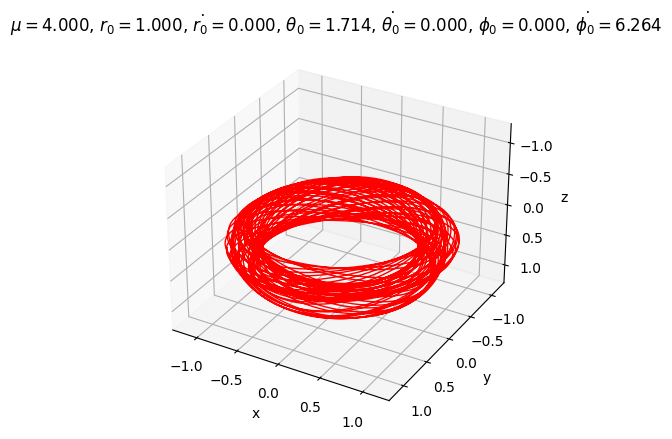

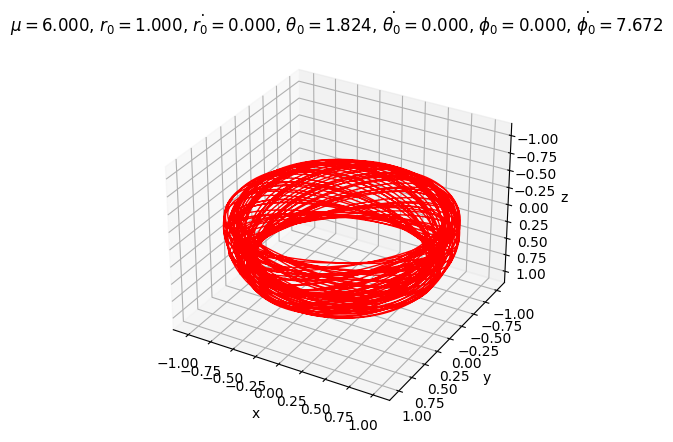

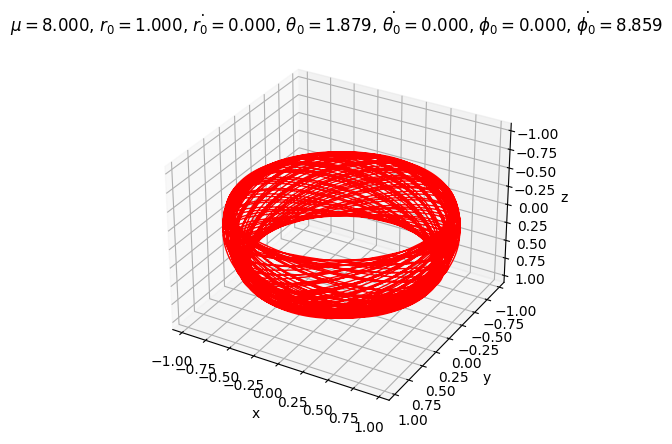

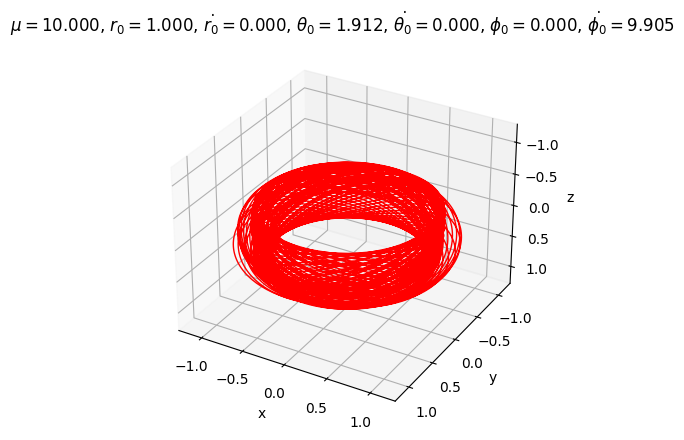

In [105]:
for i in [2,2.5,3,3.5,4,6,8,10]:
    SAM3d(i, [c_r, 0, np.arccos(1/i)*1.3, 0, 0, np.sqrt((i*g)/c_r)], 60, True, figsize=(80/9, 5))

We note that the observation of the surfaces of the cone for low $\mu$ are similar for when we perturbed $r$. However, perturbing $\theta$ for higher $\mu$ caused precession of the entire orbital plane, and we did not observe anything similar to the 'two circles' we saw previously.

#### Change $\dot\phi$

Our reasoning for perturbing this is because changing $\phi$ does not change overall motion, as the system is rotationally symmetric about the z axis. However, perhaps changing $\dot\phi$ could lead to interesting behaviors.

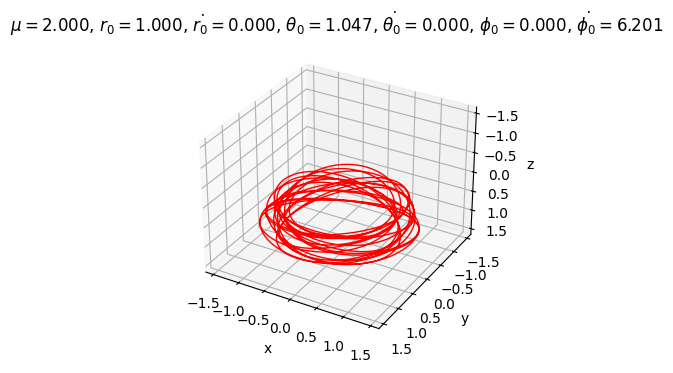

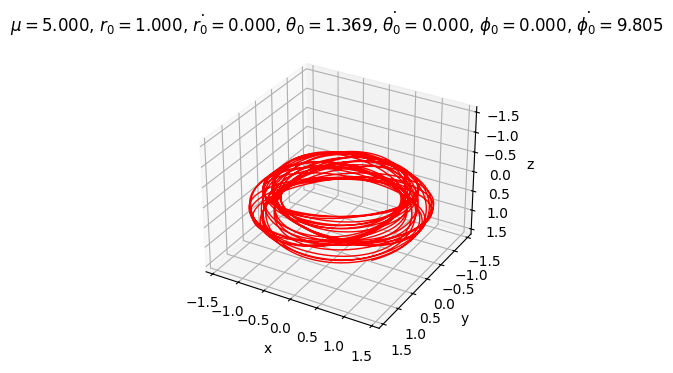

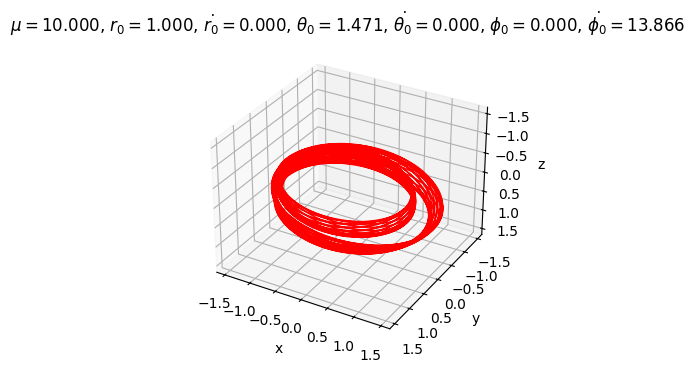

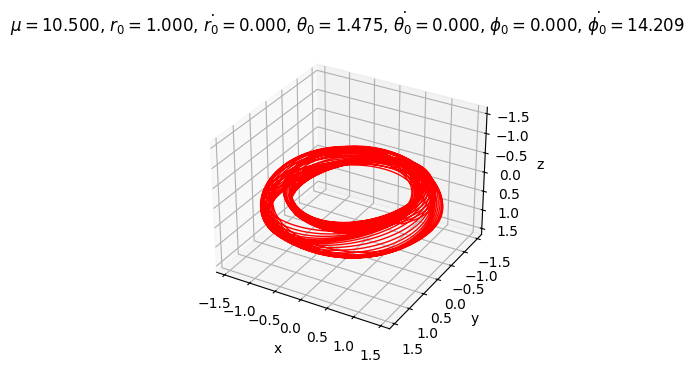

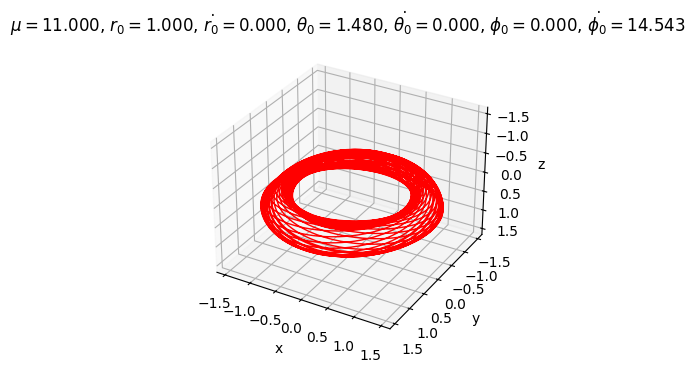

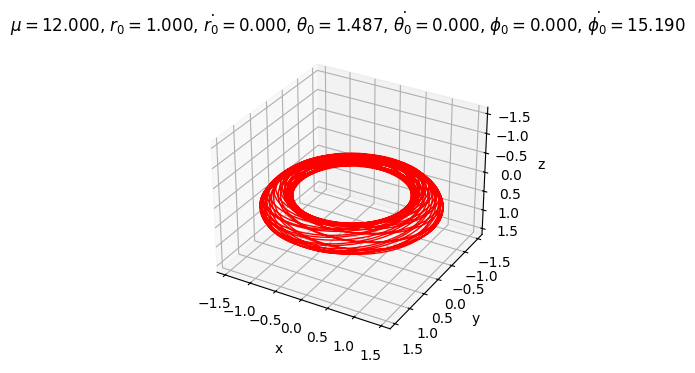

In [90]:
for i in [2,5,10,10.5,11,12]:
    SAM3d(i, [c_r, 0, np.arccos(1/i), 0, 0, np.sqrt((i*g)/c_r)*1.4], 30, True, figsize=(64/9, 4))

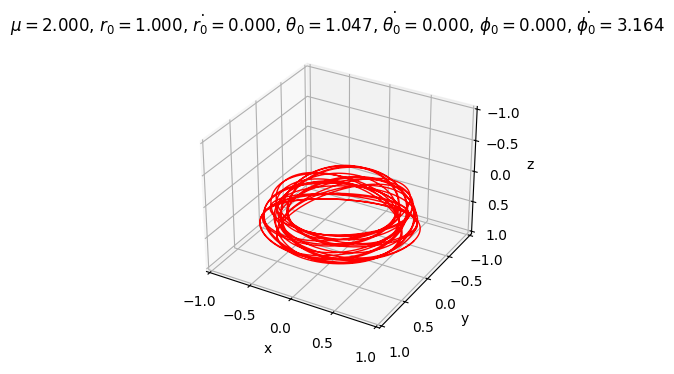

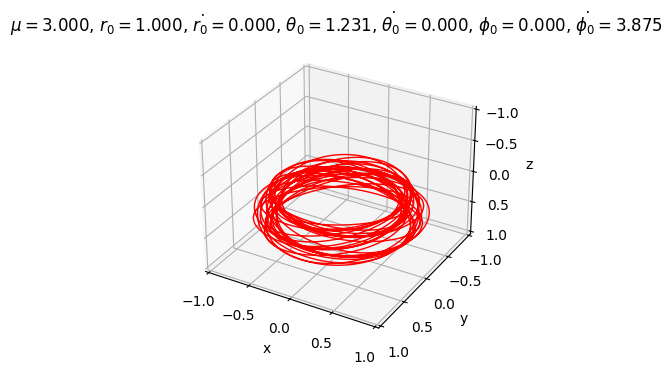

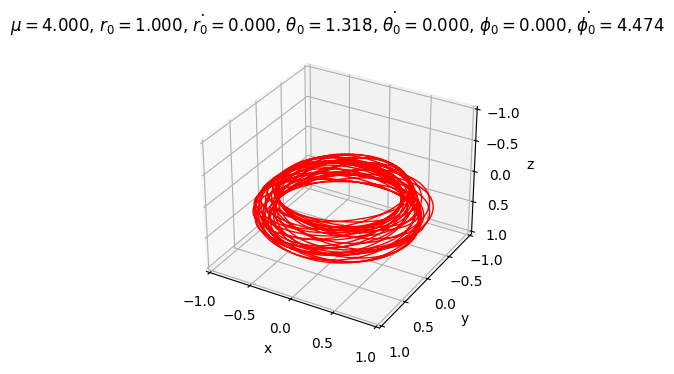

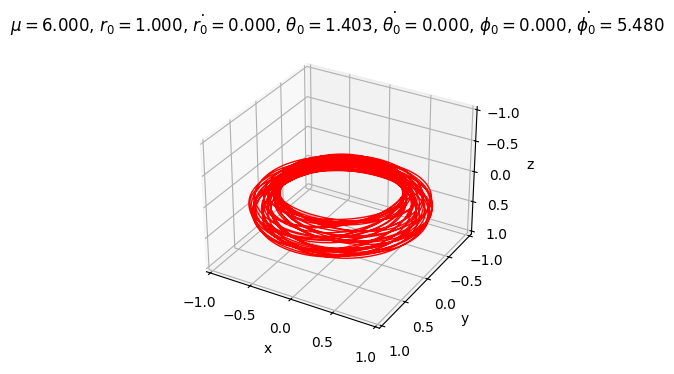

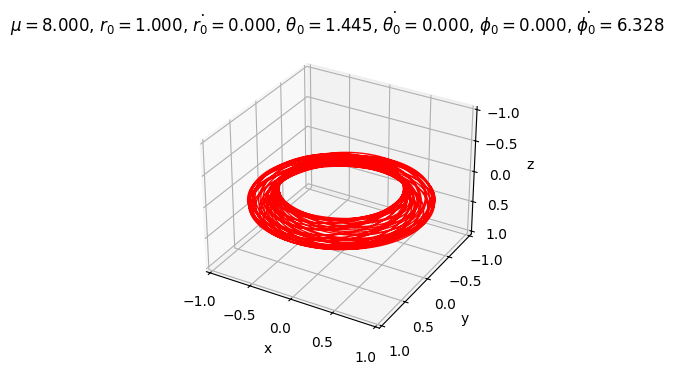

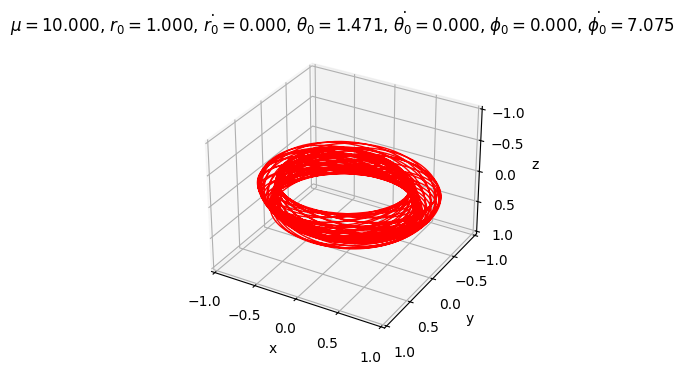

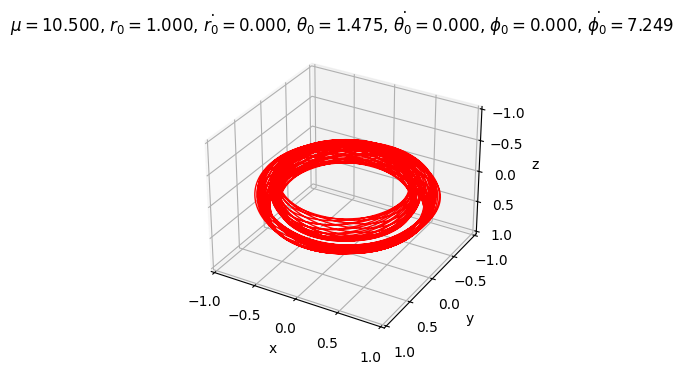

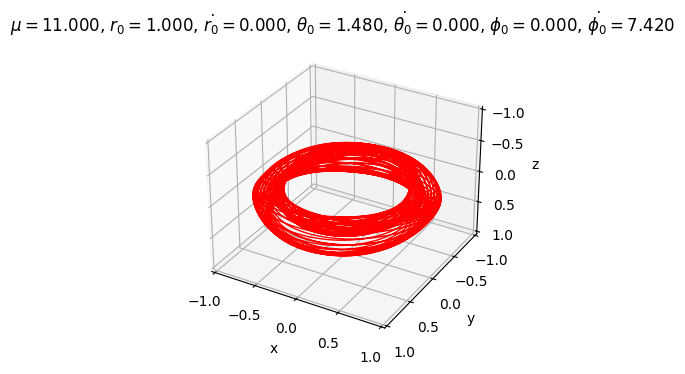

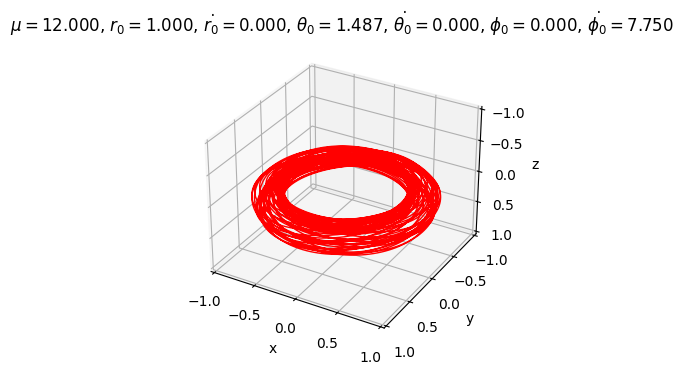

In [91]:
for i in [2,3,4,6,8,10,10.5,11,12]:
    SAM3d(i, [c_r, 0, np.arccos(1/i), 0, 0, np.sqrt((i*g)/c_r)/1.4], 30, True, figsize=(64/9, 4))

For low values of $\mu$ ($2\lt\mu\lt 4$), the resulting graph is not very comprehensible, and we cannot really extract information just from the graph alone.<br>
For $4<\mu<9$, we have roughly rotationally symmetric graphs, likely from the even precession of orbits.<br>
Most interestingly, in the neighborhood of $\mu = 10$, we have the familiar 'double circle' orbit, but with a considerable amount of oscillatory motion in the z-direction, causing an observed thickness to the trajectory.<br>
For $\mu>11$, we get more rotationally symmetric trajectories, likely with the 'double circle' being precessed around.

We will have animations for $\mu = 2.5$ and $\mu = 12$ to clearly examine motion.

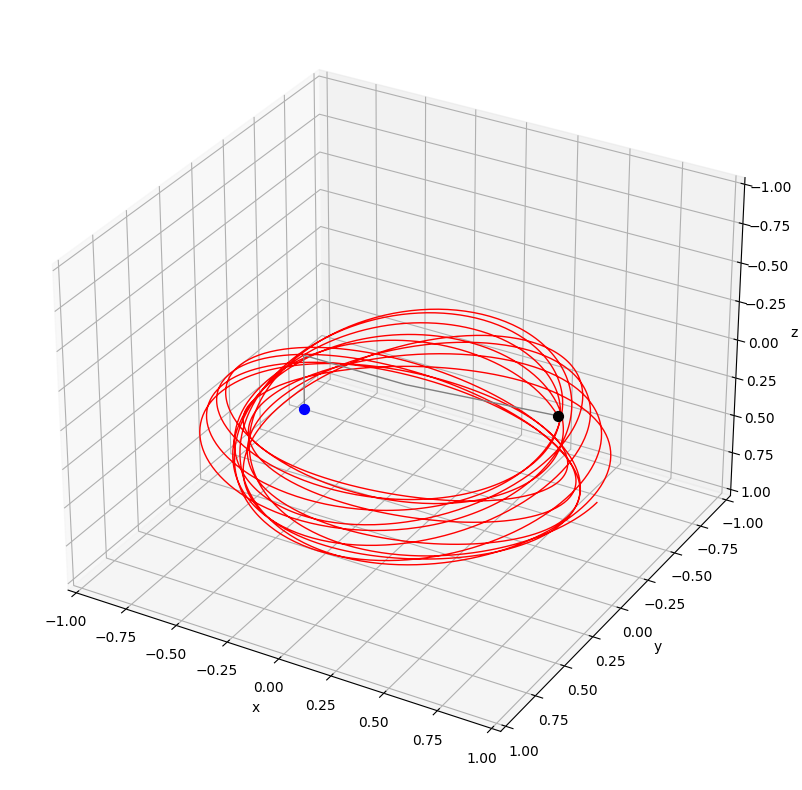

<Figure size 1777.78x1000 with 0 Axes>

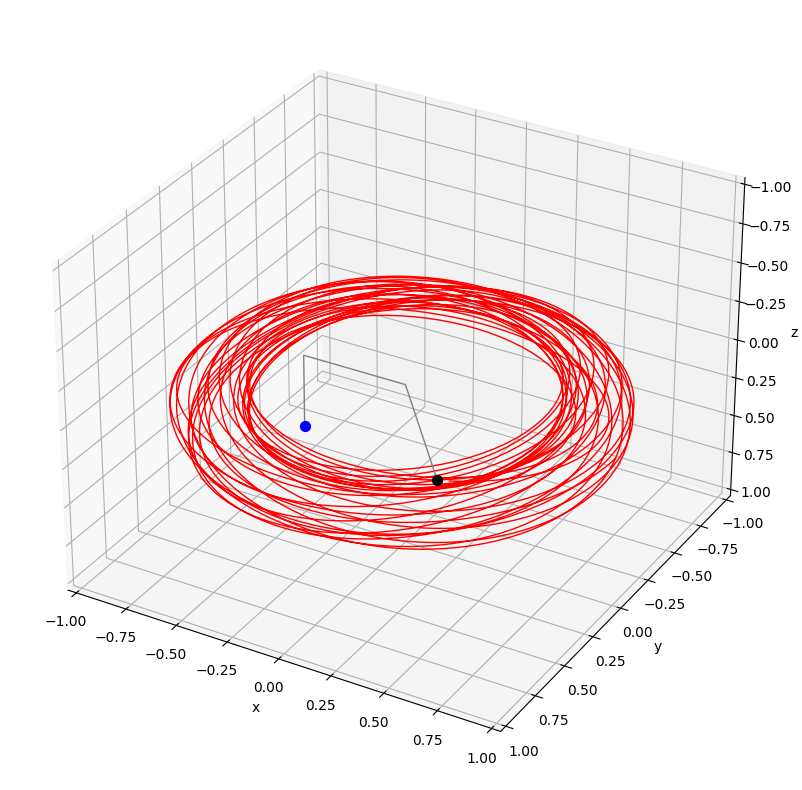

<Figure size 1777.78x1000 with 0 Axes>

In [122]:
c_mu = 2.5
anim3d(mu=c_mu, state=np.array([c_r, 0, np.arccos(1/c_mu), 0, 0, np.sqrt((c_mu*g)/c_r)/1.4]), t=15, interval=30, figsize=(160/9, 10))
c_mu = 12
anim3d(mu=c_mu, state=np.array([c_r, 0, np.arccos(1/c_mu), 0, 0, np.sqrt((c_mu*g)/c_r)/1.4]), t=15, interval=30, figsize=(160/9, 10))

As expected, at $\mu = 12$, we have the 'double circle' phenomenon, with the orbital plane rotating and moving around. <br>
However, we observe something interesting at $\mu = 2$, with a different mode of oscillation.

![](https://raw.githubusercontent.com/pgot/swingingatwood/main/img/phidot_2.5.jpg)

This one has multiple loops that clearly not coplanar. The lack of observable patterns in the cursory look we did earlier is due to the uneven precession of the orbit, which obscures the trajectory of a single period.

### Revisiting $\mu = 1.667$

We saw in earlier examinations that $\mu = 1.667$ could have a stable periodic solution in 2D. Now, we further investigate this by giving the system some velocity in the $\phi$ direction, to not restrict the movement of the system to 2D.

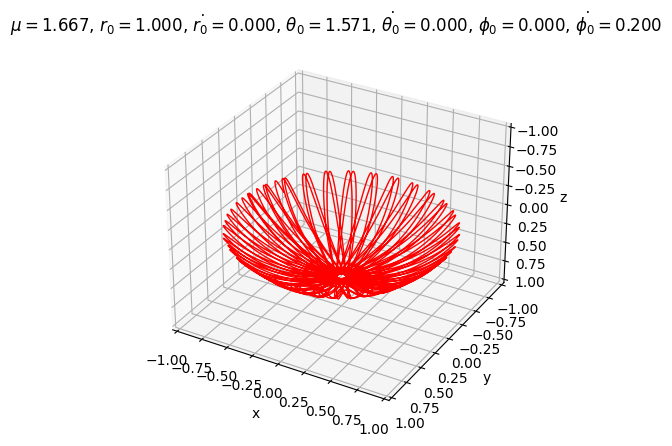

In [133]:
result_1667 = SAM3d(1.667, [1, 0, np.pi/2, 0, 0, 0.2], 60, True, figsize=(80/9, 5))

This is somewhat expected, with the vertical 2D plane that the orbit would have been restricted to without any $\dot\phi$ rotating about the z-axis, precessing the orbit.

Next, we will plot a polar graph of $r$ against $\theta$ to find similarities to the 2D case.

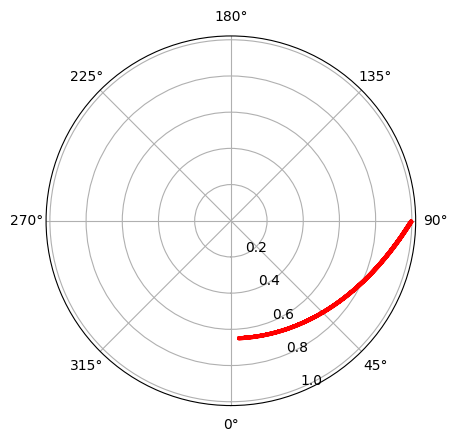

In [135]:
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
ax.set_theta_zero_location("S")
ax.plot(result_1667[THETA], result_1667[R], color='r')

There appears to be no significant deviation, but we will increase $\dot\phi$.

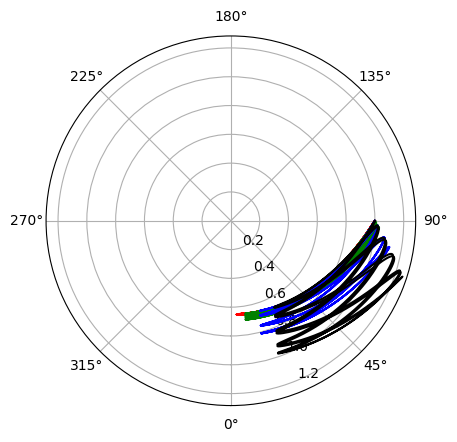

In [141]:
result_1667_2 = SAM3d(1.667, [1, 0, np.pi/2, 0, 0, 0.2], 10, False, figsize=(80/9, 5))
result_1667_5 = SAM3d(1.667, [1, 0, np.pi/2, 0, 0, 0.5], 10, False, figsize=(80/9, 5))
result_1667_10 = SAM3d(1.667, [1, 0, np.pi/2, 0, 0, 1], 10, False, figsize=(80/9, 5))
result_1667_15 = SAM3d(1.667, [1, 0, np.pi/2, 0, 0, 1.5], 10, False, figsize=(80/9, 5))
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
ax.set_theta_zero_location("S")
ax.plot(result_1667_2[THETA], result_1667_2[R], color='r')
ax.plot(result_1667_5[THETA], result_1667_5[R], color='g')
ax.plot(result_1667_10[THETA], result_1667_10[R], color='b')
ax.plot(result_1667_15[THETA], result_1667_15[R], color='black')

We observe that the 'trajectory' gets shorter and wider. This makes sense as loosely, a larger $\dot\phi$ would have a larger initial angular momentum, restricting the minimum radius where the swinging mass can go, and also restricting the range of $\theta$ values that can be reached.

# Revisiting $\dot\phi$

Previously, in our investigation when changing $\dot\phi$, we saw a 'double circle' phenomenon. This section aims to find the $\mu$ that best achieves this with the perturbation.<br>

We have manually changed the range of $\mu$ to iterate over in the below code to find the least difference from 6 full periods (corresponding to $24\pi$ in terms of $\phi$). This will minimize the precession effect and help us find the ideal $\mu$.

error +-0.05
|perturbation coefficient|$\mu$|
|----|----|
|0.95|10.55|
|1.05|10.45|
|1.1|10.4|
|1.2|10.35|
|1.3|10.275|
|1.4|10.2|
|1.5|10.15|
|1.6|10.125|

In [186]:
for i in np.linspace(10, 11, 41):
# for i in [10]:
    result = SAM3d(i, [c_r, 0, np.arccos(1/i), 0, 0, np.sqrt((i*g)/c_r)*0.75], 30, False, figsize=(160/9, 4))
    # r against phi
    # plt.plot(result[PHI][:500], result[R][:500])
    # plt.xlabel("phi")
    # plt.ylabel("r")

    # our guess of a function
    xs = np.linspace(0, 13, 100)
    ys = 1.74 - 0.24*np.cos(xs/2)
    
    twentyfourpi_index = np.argmin(np.abs(result[PHI]-12*np.pi))
    minimum_index = np.argmax(result[R][twentyfourpi_index-100:twentyfourpi_index+100])

    print(minimum_index-100, i)
    
    # plt.plot(xs, ys)

-43 10.0
-41 10.025
-40 10.05
-38 10.075
-36 10.1
-35 10.125
-34 10.15
-33 10.175
-31 10.2
-30 10.225
-28 10.25
-27 10.275
-25 10.3
-25 10.325
-23 10.35
-22 10.375
-20 10.4
-18 10.425
-17 10.45
-15 10.475
-14 10.5
-12 10.525
-11 10.55
-9 10.575
-8 10.6
-7 10.625
-6 10.65
-4 10.675
-3 10.7
-1 10.725
0 10.75
2 10.775
3 10.8
5 10.825
6 10.85
8 10.875
10 10.9
12 10.925
13 10.95
14 10.975
16 11.0


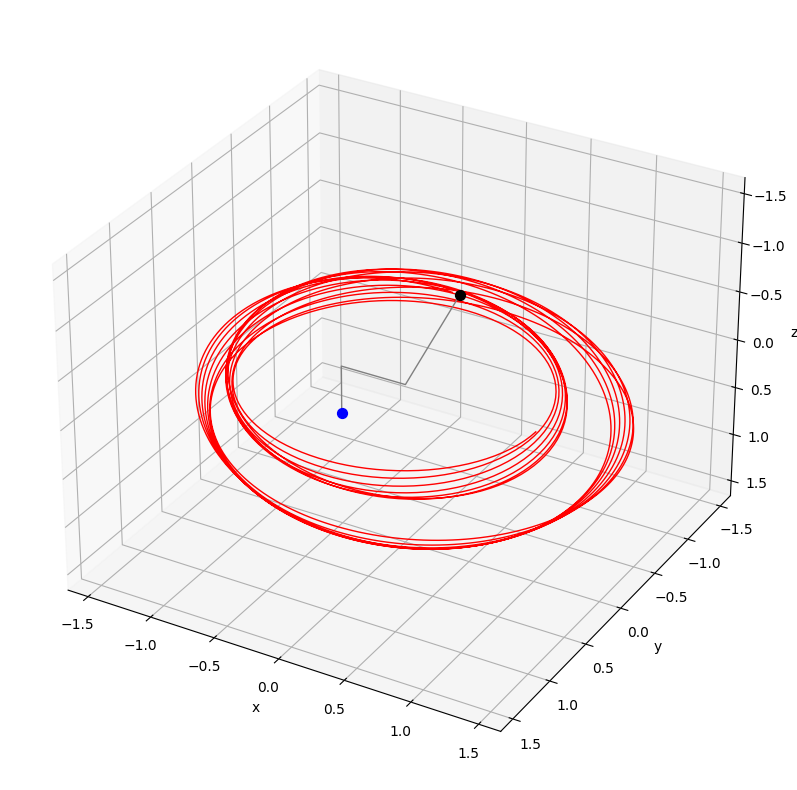

<Figure size 1777.78x1000 with 0 Axes>

In [12]:
i = 10.2
c_r = 1
anim3d(i, [c_r, 0, np.arccos(1/i), 0, 0, np.sqrt((i*g)/c_r)*1.4], 10, 30, figsize=(160/9, 10))


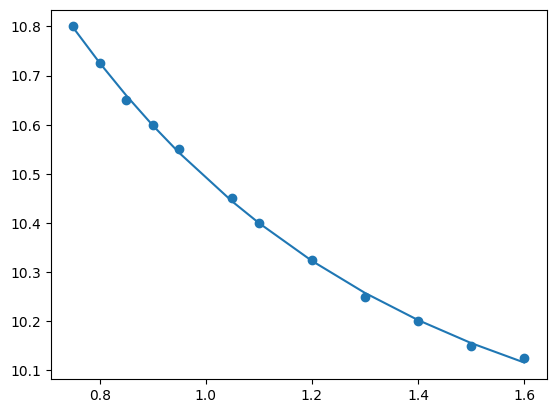

3.1391944264175886 -1.6657386379008867 9.89781636510899


In [14]:
data = np.array([[0.75, 10.8],
[0.8, 10.725],
[0.85, 10.65],
[0.9, 10.6],
[0.95,10.55],
[1.05,10.45],
[1.1,10.4],
[1.2,10.325],
[1.3,10.25],
[1.4,10.2],
[1.5,10.15],
[1.6,10.125]]).transpose()
def f(x, a, b, c):
    return c + a * np.e ** (b * x)
params = scipy.optimize.curve_fit(f, data[0], data[1], p0=[1,-1,10], maxfev=500000)

a = params[0][0]
b = params[0][1]
c = params[0][2]
plt.scatter(data[0], data[1])

predicted = [f(x, a, b, c) for x in data[0]]

plt.plot(data[0], predicted)
plt.show()
print(a, b, c)

We see that this fits $\mu = 9.898 + 3.139e^{-1.666x} $ where $x$ is the pertubation factor